

<img src="https://hsto.org/files/530/f91/bf0/530f91bf048d46b7ad9f53854d9af266.png" height="600" width="900">


# <center> R для тервера и матстата. <br>  <br> 5.1 Титаник. </center>

Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2017-2018). Автор ноутбука [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/R_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

---------

В прошлый раз мы попытались просечь метод максимального правдоподобия и оценили парочку простых моделей. Сегодня мы продолжим разбираться с ним и оценим свою первую настоящую модель. Она называется логистической регрессией и очень часто, с небольшими видоизменениями, используется на практике.


# 1. Регрессия и классификация: что это такое и зачем надо


* дописать 1 пункт 
* вставить картинку в предобработку данных 
* выбросить пропуски!





# 2. Что мы хотим, а также предобработка данных 

У нас в руках есть данные о пассажирах титаника с [соревнования на Kaggle](https://www.kaggle.com/c/titanic) (Kaggle -это такая платформа для проведения соревнований по анализу данных. Там много чего интересного есть). __Наша цель:__ научиться предсказывать умрёт ли пассажир титаника по его характеристикам. Это задача классификации. Нам нужно научиться разбивать все объекты на две категории. Попутно неплохо было бы научиться предсказывать вероятность смерти. 

Подгружаем все необходимые пакеты. Если каких-то из них у нас нет, устанавливаем.

In [2]:
library('dplyr')
library('ggplot2')
library('maxLik') # пакет для метода макс. правдоподобия
options(repr.plot.width=4, repr.plot.height=3)

Выборка пассажиров титаника разбита на две части: тренировочную и тестовую. Обычно, на тренировочной выборке учат модель, на тестовой выборке проверяют насколько хорошо она работает. Выборка, на которой мы учимся, не подходит для этих целей. Так как знания об этих объектах уже будут лежать в нашей модели, а в реальной жизни будут встречаться и новые, ранее неизвестные объекты. Часть, которую мы отложили, алгоритм ещё не видел. Значит можно использовать её для имитации этих самых новых объектов из реальной жизни и посмотреть какое на них будет качество. 

Такой подход помогает избежать переобучения модели. __Переобучением__ называют ситуации, когда модели тупо запоминают тренировочную выборку вместо того, чтобы извлечь из неё какие-то закономерности. Обычно на обучение пускают $70-80\%$ выборки, а на тестирование $30-20\%$.

In [3]:
df = read.csv('/Users/fulyankin/Yandex.Disk.localized/R/R_prob_data/titanic_train.csv', sep=',')

In [4]:
# Можно посмотреть на первые пять строк!
head(df, 5)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S


In [5]:
# Можно посмотреть на последние пять строк!
tail(df, 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
887,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.00,,S
888,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.00,B42,S
889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NA,1,2,W./C. 6607,23.45,,S
890,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.00,C148,C
891,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,,Q


In [6]:
# Можно кинуть свой взор на таблицу и посмотреть какой тип у каких переменных 
glimpse(df)

Observations: 891
Variables: 12
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, ...
$ Survived    <int> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0...
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3...
$ Name        <fctr> Braund, Mr. Owen Harris, Cumings, Mrs. John Bradley (F...
$ Sex         <fctr> male, female, female, female, male, male, male, male, ...
$ Age         <dbl> 22, 38, 26, 35, 35, NA, 54, 2, 27, 14, 4, 58, 20, 39, 1...
$ SibSp       <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1...
$ Parch       <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0...
$ Ticket      <fctr> A/5 21171, PC 17599, STON/O2. 3101282, 113803, 373450,...
$ Fare        <dbl> 7.2500, 71.2833, 7.9250, 53.1000, 8.0500, 8.4583, 51.86...
$ Cabin       <fctr> , C85, , C123, , , E46, , , , G6, C103, , , , , , , , ...
$ Embarked    <fctr> S, C, S, S, S, Q, S, S, S, C, S, S, S, S, S, S, Q, S, ...


Давайте наконец выясним, что какая переменная обозначает.

* Survived - выжил человек или нет, целевая переменная 
* Pclass - класс, в котором ехал человек 
* Name - имя человека 
* Sex - пол 
* Age - возраст 
* SibSp - сколько было на борту братьев, сестер, супругов на борту Титаника
* Parch - число детей и родителей на борту Титаника 
* Ticket - номер билета 
* Fare - стоимость билета 
* Cabin - номер каюты 
* Embarked - порт посадки (C = Шербур, Q = Квинстаун, S = Саутгемптон) 

Часть из этих переменных являются действительными (возраст, цена билета), часть категориальными (класс, в котором плыл человек, пол человека). В выдаче от `glimse` числовые переменные обозначены как `<int>` и `<dbl>`. Для категориальных переменных у R есть свой специальный тип, `<fctr>`, факторный. Это бывает очень удобно при оценке моделей.

Дело в том, что метод максимального правдоподобия (как в прочем и любые другие методы и модели) понимает только цифры. Напрмер, он не знает что такое `male` и `female` и не может посчитать от них среднее. Приходится придумывать способы перегнать такие переменные в цифры. В случае пола, например, можно обозначить всех мужчин единичками, а всех женщин нулями. Тогда итоговая модель, получая единичку, будет понимать, что c ней делать, а мы будем понимать, что она делает это с мужчинами. Такая переменная, принимающая два значения: ноль и один, называется __дамми-переменной.__

В случае более сложных переменных, например порта посадки, возникает желание переобозначить Шербур за единички, Квинстаун за двойки, а Саутгемптон за тройку.  Это неправильный подход. Если так сделать, то алгоритмы будут дамать, что третий порт самый лучший, а первый самый плохой. Очень большой вопрос почему мы определили порядок портов именно так. Это запутает модель. Чтобы не путать алгоритм, поступают следующим образом: делают из категориальной переменной много дамми. Вот так:


![ ]( )

Если человек плыл из порта $C$, то у него в соответствующем столбце будет стоять единичка, а в остальных нули. По аналогии получится с другими портами. 

__Приятный бонус:__  Не нужно бороться с пропусками в данных. Для пропусков будет своя дамми и мы не потеряем информации. Такой способ работы с категориями называется One Hot Encoding. Дословно можно перевести как одно горячее кодирование.

В чём минус одного горячего кодирования? Можно обжечься. Если категорий внутри переменной много, то мы переработаем её в слишком большое число столбцов. В конечном итоге это может привести к тому, что модели не хватит наблюдений, чтобы научиться в этом огромном числе столбцов ориентироваться.

Есть и другие способы обработки категориальных переменных, но мы будем пользоваться этим. Он самый простой. Более того, тип переменной `<fctr>` позволяет делать это по дефолту без предобработки. Обратите внимание, что часть категориальных переменных, R воспринял как числовые. Это нужно исправить.

In [7]:
# команда mutate делает из выборки мутанта, изменяя её :)
df <- mutate(df, Pclass=as.factor(Pclass), Survived=as.factor(Survived))

На самом деле, на этом предобработка переменных не заканчивается, есть огромное количество тонкостей. Большую часть времени аналитики проводят, подготавливая данные. Меньшую часть, оценивая модели. Всем этим тонкостям посвящён курсы по машинному обучению и эконометрике. Мы же всё ещё в курсе матстата, поэтому в этом блокноте сосредоточимся на методе максимального правдоподобия. 

In [41]:
# Выбросим неинтересные для нас переменные и посмотрим по интересным основную статистику

variables <- c('Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare')
df = df[variables]

summary(df[c( 'Age', 'SibSp', 'Parch', 'Fare')])

      Age            SibSp           Parch             Fare       
 Min.   : 0.42   Min.   :0.000   Min.   :0.0000   Min.   :  0.00  
 1st Qu.:20.12   1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:  7.91  
 Median :28.00   Median :0.000   Median :0.0000   Median : 14.45  
 Mean   :29.70   Mean   :0.523   Mean   :0.3816   Mean   : 32.20  
 3rd Qu.:38.00   3rd Qu.:1.000   3rd Qu.:0.0000   3rd Qu.: 31.00  
 Max.   :80.00   Max.   :8.000   Max.   :6.0000   Max.   :512.33  
 NA's   :177                                                      

In [43]:
summary(df[c('Survived', 'Pclass', 'Sex')])

 Survived Pclass      Sex     
 0:549    1:216   female:314  
 1:342    2:184   male  :577  
          3:491               

Разобьём выборку, как и планировали в самом начале, на тестовую и тренировочную. 

In [44]:
RowIndex <- sample(1:nrow(df), round(0.8*nrow(df)))  # отбираем рандомные индексы для теста и трэйна
RowIndex[1:10]

[1] 736 815 800 850 323 845 111  92   6 201

In [45]:
df_train <- df[RowIndex, ]  # тренировчная будет состоять из 80% наблюдений
df_test <- df[-RowIndex, ]  # тестовая будет состоять из 20%

In [46]:
dim(df_train)
dim(df_test)

[1] 713   7

[1] 178   7

# 3. Немного картинок

Давайте построим пару визуализаций датасета и порассуждаем о том, что в нём происходит. 

In [47]:
# картинка с балансом между классами
# матрица корреляций 
# распределение всех признаков 

Warning message:
“Removed 141 rows containing non-finite values (stat_ydensity).”

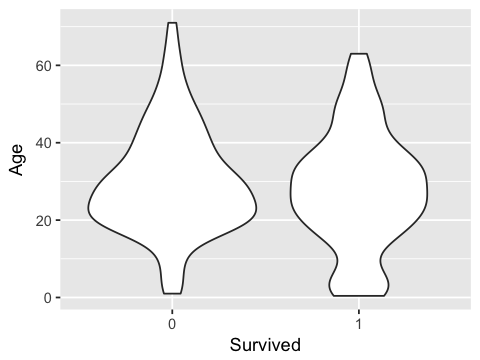

In [48]:
qplot(data=df_train,x=Survived,y=Age,geom="violin")


#если поделить пассажиров на выживших и не выживших
#и отдожить по вертикали количественную переменную
#а именно возраст, то мы видим что возраст меняется от
# 0 до 80 и среди тех и других по возрастам распределение
# примерно одинаковое.

Warning message:
“`position` is deprecated”Warning message:
“Removed 141 rows containing non-finite values (stat_density).”

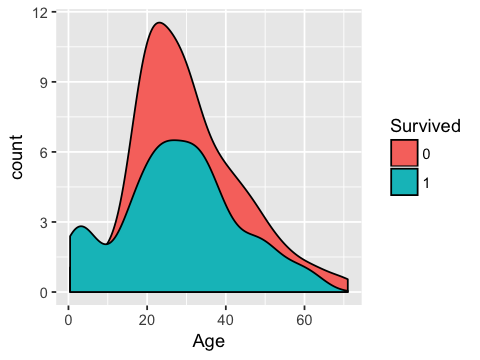

In [49]:
#Построим плотности выживших и невыживших на одном графике. 
qplot(data=df_train, x=Age, y=..count.., fill=Survived, geom="density", position="stack")
#                             количество    закраска                    как расположены     
#                             наблюдений    в соотв.                    накапливаются по   
#                             комп сам      выжил или нет               вертикали


Все эти закономерности надо каким-то образом учесть, при оценивании вероятности выживания. Ещё больше картинок можно найти [в статье по титанику на хабре.](https://habr.com/company/mlclass/blog/270973/)

# 4. Оцениваем модель!

## 4.1 Данные? Какие данные?

На первои шаге забудем про все переменные, кроме выживаемости. Вытащим из таблицы только колонку из нулей и единиц, где $1$ означает, что человек выжил, а $0$, что нет. По этой колонке нам хотелось бы оценить вероятность выживания. До сегодняшнего дня мы делали это следущим способом:

$$
L = p \cdot p \cdot \ldots \cdot p \cdot (1-p) \cdot (1-p) \cdot \ldots \cdot (1-p) = p^{\sum_{i=1}^n y_i} \cdot (1-p)^{n- \sum_{i=1}^n y_i}.
$$

Прологорифмировав, мы получали функцию для оптимизации:

$$
\ln L = \sum_{i=1}^n y_i \ln p + (n- \sum_{i=1}^n y_i) (1-p).
$$

Немного технических сложностей. Помните, мы сделали переменную `Survived` факторной?

In [50]:
str(df_train$Survived)

 Factor w/ 2 levels "0","1": 1 1 1 2 2 1 1 1 1 1 ...


Если мы захотим работать с ней не в рамках готовых для моделирования пакетов, начнут возникать проблемы.

In [51]:
mean(df_train$Survived)

Warning message in mean.default(df_train$Survived):
“argument is not numeric or logical: returning NA”

[1] NA

Давайте до поры, до времени, вернём нашей переменной числовой тип. Если мы сделаем это командой `as.numeric` от столбца, на метсо нулей и единиц подставятся номера категорий (факторов). В данном случае, либо первая, либо вторая. Это плохо, потому что изначально категории были закодированы нулями и единицами.

In [52]:
str(as.numeric(str(df_train$Survived)))

 Factor w/ 2 levels "0","1": 1 1 1 2 2 1 1 1 1 1 ...
 num(0) 


Чтобы избежать этого, придётся сделать переменную сначала тектсовой, потом уже числовой.

In [53]:
str(as.numeric(as.character(df_train$Survived)))

 num [1:713] 0 0 0 1 1 0 0 0 0 0 ...


Это была малоприятная техническая деталь, которая обычно взрывает мозг многим ребятам, которые впервые работают в R с таблицами. Поэтому я решил это тут показать. Пришло время вбить функцию логарифма правдоподобия и посмотреть на пару её значений в разных точках.

In [54]:
# вернём пока что числовой тип целевой переменной 
df_train = mutate(df_train, Survived = as.numeric(as.character(Survived)))

y_sur = df_train$Survived

lnL <- function(p,y){
    ans <- sum(y)*log(p) + (length(y) - sum(y))*(1-p)
  return(ans)
}

lnL(0.5, c(1,0,1,0,1))
lnL(0.5, y_sur)

[1] -1.079442

[1] 31.96397

Оптимизируем! 

In [55]:
res <- maxLik(lnL, start=0.5, y = y_sur) # какую стартовую точку взять? 
summary(res)                             # 0.5 это логично для оценки вероятности 

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 4 iterations
Return code 1: gradient close to zero
Log-Likelihood: 37.55796 
1  free parameters
Estimates:
     Estimate Std. error t value Pr(> t)    
[1,]   0.6168     0.0374   16.49  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [56]:
mean(y_sur)  # всё ок! :) Получили ожидаемый результат.

[1] 0.3814867

Для того, чтобы в дальнейшем нам было удобно сопоставлять разные формулы, давайте перепишем уже полученное выше правдоподобие немного иначе и прологарифмируем

$$
L = \prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i}
$$

$$
\ln L = \sum_{i=1}^n [y_i \ln p + (1-y_i) \ln(1-p)].
$$

## 4.2 Линейная вероятностная модель

Итак, что только что произошло? Мы получили вероятность того, что человек выживет на титанике. Она для каждого из нас равна $0.38$. На интуитивном уровне сразу же понятно, что это очень плохая оценка. Она никак не учитывает в себе, что люди бывают разными.

На картинках выше, мы с вами увидели, что для женщин вероятность выжить намного больше, чем для мужчин. Было бы неплохо оценить для мужчин свою вероятность, а для женщин свою. Мы, зная, что $\hat p_{ML} = \bar x$, легко можем сделать это. Заодно изучим прикольный приём под названием __трубочка.__  Если мы хотим взять синус от числа, а потом прологорифмировать, мы можем сделать это так:

In [57]:
log(sin(8))

[1] -0.01069878

Если мы хотим от этого взять ещё косинус, то слева нужно дописать новую функцию.

In [58]:
cos(log(sin(8)))

[1] 0.9999428

Постоянно надо будет плодить новые скобки и ... это не удобно. Легко забыть или запутаться. Особенно когда ты работаешь с таблицами. Для того, чтобы не путаться, внутри пакета `dplyr` лежит трубочка: удобная опирация для последовательных дйствий.

In [59]:
8 %>% sin %>% log %>% cos

[1] 0.9999428

Это выглядит так как будто мы берём число $5$ и пропускаем его через трубочку по очереди в каждую функцию. Никаких скобок и удобно. Обычно трубочками работают с таблицами. Например, ниже мы отфильтровали в таблице все строки с мужчинами, а затем посчитали среднее по колонке `Survived`.

In [60]:
df_train %>% filter(Sex == 'male') %>% summarise(male_p = mean(Survived))
df_train %>% filter(Sex == 'female') %>% summarise(female_p = mean(Survived))

male_p
0.187905


female_p
0.74


Такая оценка будет намного лучше нашей первой. Но стоит ли останавливаться на этом? Нет! Идея требует своего развития. Кажется, что вероятность выжить это функция от всех параметров, которыми обладает человек

$$p = F(age, sex, ...).$$ 

Предположим, что она линейная, то есть каждый фактор, пол, возраст и тп, взвешиваются с какими-то весами, $\beta$, и получается вероятность

$$p = \beta_0 + \beta_1 sex + \beta_2 age + \ldots.$$

Например, как мы уже выяснили, женщины выживают чаще мужчин, более старые люди выживают редко. Возможно, что $p = 0.2*sex - 0.01 age_i$. Тогда получится, что если переменная $sex$ принимает значение $1$, вероятность выжить подскакивает на $0.2$. При этом, с каждым прожитым годом, вероятность выжить падает. Осталось только понять откуда взять эти две бэты.  

Найти методом максимального правдоподобия! Берём и заменям в нашей изначальной формуле все $p$ на $F(x)$ и занимаемся её оптимизацией по параметрам $\beta$

$$
\ln L = \sum_{i=1}^n [y_i \ln F(x_i) + (1-y_i) \ln(1-F(x_i))].
$$

Попробуем для начала сделать это только с полом:

$$
\ln L = \sum_{i=1}^n [y_i \ln (\beta_0 + \beta_1 sex_i) + (1-y_i) \ln(1-(\beta_0 + \beta_1 sex_i))].
$$

В каждом слагаемом находится своё уникальное значение $sex_i$. Из-за этого у нас не получится так просто вбить функцию правдоподобия, как мы сделали это выше. Хорошо, что у нас есть матрицы и линал, которые помогут :) Предположим, что у нас есть вот такая вот табличка из четырёх наблюдений: 

$$
X = \begin{pmatrix} 1 & sex_1 \\ 1 & sex_2 \\ 1 & sex_3 \\ 1 & sex_4 \end{pmatrix} 
$$

Во втором столбике записано то, какого пола каждый человек. В первом столбике написаны единички. Это небольшой технический приём, чтобы получить потом $\beta_0$. Запишем вектор из $\beta$ в виде столбика:

$$
\beta = \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix}
$$

Тогда если мы перемножим матрицу $X$ и столбик $\beta$, то мы получим 

$$
X \cdot \beta = \begin{pmatrix} \beta_0 + \beta_1 sex_1 \\ \beta_0 + \beta_1 sex_2 \\ \beta_0 + \beta_1 sex_3 \\\beta_0 + \beta_1 sex_4 \end{pmatrix}
$$

Домножим каждой слагаемое на свой $y_i$, тогда: 

$$
y*X \cdot \beta = \begin{pmatrix} y_1 \cdot(\beta_0 + \beta_1 sex_1) \\ y_2 \cdot(\beta_0 + \beta_1 sex_2) \\ y_3 \cdot(\beta_0 + \beta_1 sex_3) \\ y_4 \cdot(\beta_0 + \beta_1 sex_4) \end{pmatrix}
$$

Если мы просуммируем всё это, то получим первый кусочек суммы. Аналогично можно получить второй кусочек. Давайте вобьём это в R.

In [61]:
X <- cbind(1,runif(5))  # cbind объединяет столбики
X # матрица из наблюдений

1,0.2548366
1,0.1412458
1,0.3679176
1,0.3228432
1,0.1873537


In [62]:
b <- c(2, 4)
b # вектор из параметров

[1] 2 4

In [63]:
X%*%b  # матричное умножение 

3.019346
2.564983
3.471670
3.291373
2.749415


In [64]:
y <- c(0,1,0,1,1)
y*log(X%*%b)   # домножаем поэлементно на соответствующие игреки и получаем первое слагаемое 

0.000000
0.941952
0.000000
1.191305
1.011388


In [65]:
(1-y)*log(1 - X%*%b)  # при поиске второго слагаемого возникли проблемы :(

Warning message in log(1 - X %*% b):
“созданы NaN”

NaN
NaN
NaN
NaN
NaN


In [66]:
# Откуда проблемы? Отрицательные числа под логарифмами. 
1 - X%*%b

-2.019346
-1.564983
-2.471670
-2.291373
-1.749415


In [67]:
# Итоговое правдоподобие выглядело бы вот так:

lnL <- function(beta,y,X){
    ans <- sum(y*log(X%*%b) + (1-y)*log(1 - X%*%b))
  return(ans)
}

# Можно даже подбрать ситуации, когда с ним всё окей и нет ошибок:
y <- c(0,1)
X <- cbind(1,c(1/16,1/16))
b <- c(0.5,0.5)
lnL(b,y,X)

[1] -1.390208

Когда мы предположили, что $p = \beta_0 + \beta_1 sex_i$, мы оказались неправы. Наш главный косяк был в том, что вероятность должна принимать значения от нуля до единицы. При предположенной нами зависимости, возникают ситуации, когда она пробивает этот диапазон. Из-за этого под логарифм попадают отрицательные числа и вся концепция рушится. Нужно исправить это.









$$
\ln L = \sum_{i=1}^n [y_i \ln (\beta_0 + \beta_1 sex_i) + (1-y_i) \ln(1-(\beta_0 + \beta_1 sex_i))].
$$

In [68]:
sigmoid <- function(z){
    return(exp(z)/(1 + exp(z)))
}

sigmoid(5)

[1] 0.9933071

In [69]:
lnL <- function(b, y, X){
    answ = sum(y*log(sigmoid(-1*X%*%b)) + (1-y)*log(1 - sigmoid(-1*X%*%b)))
    return(answ)
}

y <- c(0,1)
X <- cbind(1,c(1/16,1/16))
b <- c(0.5,0.5)
lnL(b,y,X)

[1] -1.456037

In [70]:
# Пол нужно сделать числовым вида 1 - мужчины, 0 - женщины
X = cbind(1, as.numeric(df_train$Sex) - 1)
lnL(b,y_sur,X)

[1] -443.0594

In [71]:
res <- maxLik(lnL, start=c(0.5,0.5), y = y_sur, X = X)  
summary(res)                                    

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 4 iterations
Return code 1: gradient close to zero
Log-Likelihood: -366.9723 
2  free parameters
Estimates:
     Estimate Std. error t value  Pr(> t)    
[1,]  -1.0460     0.1443  -7.249 4.19e-13 ***
[2,]   2.5096     0.1870  13.420  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [72]:
# Пол нужно сделать числовым вида 1 - мужчины, 0 - женщины
X = cbind(1, as.numeric(df_train$Sex) - 1, df_train$Age)

res <- maxLik(lnL, start=c(0.5,0.5,2), y = y_sur, X = X)  
summary(res)    

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 0 iterations
Return code 100: Initial value out of range.
--------------------------------------------

In [73]:
X[1:7,]

1,1,28.5
1,1,30.5
1,0,30.0
1,0,NA
1,0,30.0
1,1,17.0
1,1,47.0


In [74]:
df_drona_age <- df_train[!is.na(df_train['Age']),]
y <- df_drona_age$Survived
X <- cbind(1, as.numeric(df_drona_age$Sex) - 1, df_drona_age$Age)

res <- maxLik(lnL, start=c(0.5,0.5,2), y = y, X = X)  
summary(res)   

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 36 iterations
Return code 2: successive function values within tolerance limit
Log-Likelihood: -301.8593 
3  free parameters
Estimates:
      Estimate Std. error t value  Pr(> t)    
[1,] -1.338116   0.259632  -5.154 2.55e-07 ***
[2,]  2.447614   0.206627  11.846  < 2e-16 ***
[3,]  0.007366   0.007133   1.033    0.302    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

## 4.3 Всё то же самое, но более удобно

  

In [75]:

df_train <- mutate(df_train, Survived = as.factor(Survived))

m_logit <- glm(data=df_train, Survived~Sex+Age+Pclass+Fare, 
                  family=binomial(link="logit"))

summary(m_logit)


Call:
glm(formula = Survived ~ Sex + Age + Pclass + Fare, family = binomial(link = "logit"), 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6965  -0.6733  -0.4181   0.6997   2.4188  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.7939160  0.5206429   7.287 3.17e-13 ***
Sexmale     -2.5158249  0.2295258 -10.961  < 2e-16 ***
Age         -0.0371725  0.0086354  -4.305 1.67e-05 ***
Pclass2     -1.4189482  0.3525852  -4.024 5.71e-05 ***
Pclass3     -2.4695322  0.3640186  -6.784 1.17e-11 ***
Fare        -0.0007299  0.0026237  -0.278    0.781    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 773.95  on 571  degrees of freedom
Residual deviance: 529.84  on 566  degrees of freedom
  (141 observations deleted due to missingness)
AIC: 541.84

Number of Fisher Scoring iterations: 4


In [76]:
vcov(m_logit)

,(Intercept),Sexmale,Age,Pclass2,Pclass3,Fare
(Intercept),0.2710690010,-0.0526697372,-3.335665e-03,-0.1289658568,-0.1587789050,-7.305329e-04
Sexmale,-0.0526697372,0.0526820792,1.705887e-04,0.0143830286,0.0216568883,6.890740e-05
Age,-0.0033356654,0.0001705887,7.457066e-05,0.0010580292,0.0015074455,3.381941e-06
Pclass2,-0.1289658568,0.0143830286,1.058029e-03,0.1243163136,0.0915724422,4.401786e-04
Pclass3,-0.1587789050,0.0216568883,1.507445e-03,0.0915724422,0.1325095211,5.226304e-04
Fare,-0.0007305329,0.0000689074,3.381941e-06,0.0004401786,0.0005226304,6.883981e-06


Построим прогнозы для тестовой выборки!

In [86]:
pr_logit <- predict(m_logit, df_test[,-1], se=TRUE)  # Строим прогнозы по нашей модели на тесте 
df_test <- cbind(df_test, pr_logit) # объеядиним прогнозы с тестовой табилчкой 
head(df_test)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fit,se.fit,residual.scale
4,1,1,female,35,1,0,53.1000,2.4541224,0.2886515,1
14,0,3,male,39,1,5,31.2750,-2.6639953,0.2590235,1
16,1,2,female,55,0,0,16.0000,0.3188024,0.3330361,1
21,0,2,male,35,0,0,26.0000,-1.4608712,0.2381417,1
25,0,3,female,8,3,1,21.0750,1.0116218,0.2386977,1
29,1,3,female,NA,0,0,7.8792,NA,NA,1


ERROR: Error in mutate(newdata_pr, prob = plogis(fit), left_ci = plogis(fit - : объект 'newdata_pr' не найден


In [ ]:

head(newdata_pr)
#переменная fit - предсказанная y* residual.scale - вспомогательная 

#Доверительный интервал для вероятности и LR тест в R
newdata_pr <- mutate(newdata_pr,prob=plogis(fit),
                     left_ci=plogis(fit-1.96*se.fit),
                     right_ci=plogis(fit+1.96*se.fit))
head(newdata_pr)

#Проилюстрируем графически
qplot(data=newdata_pr, x=age,y=prob,geom="line")
#видим, что при росте возраста вероятность выжить падает
qplot(data=newdata_pr, x=age,y=prob,geom="line")+
  geom_ribbon(aes(ymin=left_ci,ymax=right_ci),alpha=0.2)
#добавили доверительные интервалы. Точность прогнозирования
# увеличивается с возрастом, т.к. мало детей




Последний шаг для этого скрипта. Зная качество прогнозов на тестовой выборке, давайте построим прогноз для себя.

Логичтическая регрессия очень часто используется на практике. Многие модели, которые работают у крупных фирм в продакшене это именно она. Правда немного модернизированная. 

Первая модернизация заключается в метрике, по которой оценивается работоспособность модели. Мы посмотрели выше на качество работы нашей модели по метрике, которая называется Accuracy (доля верных ответов). Интуитивно понятная, очевидная и почти неиспользуемая метрика. 

Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правлиьных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики. Про них можно найти более подробную информацию в почиташках.  


## Почиташки

* [Моя статья из иканам гранд рисёрча]() с небольшим введением в машинное обучение. Там я строил для предказани отчисяемости людей именно логистическую регрессию. В этой же статейке можно почитать про другие метрики качества.
* [Статья на хабре]() про метрики, которые используются для оценки качества моделей.
* [Ршение титаника в R с хабра]() от какого-то парня. В этой статейке можно углубиться в код, если есть такое желание.

<img src="https://ic.pics.livejournal.com/kobayashi_corp/71797700/3420/3420_original.jpg" height="600" width="600">
